In [ ]:
from roboflow import Roboflow
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

The data in Roboflow can be found [here](https://app.roboflow.com/master-thesis-ws6ag/thesis-kitchen-objects/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true).


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="c9NVDRnbPv8dXJSTZOpd")
project = rf.workspace("master-thesis-ws6ag").project("kitchen-objects-with-hands")
version = project.version(1)
dataset = version.download("yolov8")

## Convert Polygons to Bounding Boxes

In [3]:
# Paths to train, test, and validation labels
label_folders = [
    'Kitchen-Objects-with-Hands-1/train/labels',
    'Kitchen-Objects-with-Hands-1/test/labels',
    'Kitchen-Objects-with-Hands-1/valid/labels'
]

In [4]:
def polygon_to_normalized_bbox(coords):
    """
    Convert normalized polygon coordinates to normalized bounding box.
    Input: coords = [x1, y1, x2, y2, ..., xn, yn] in range [0, 1]
    Output: (x_center, y_center, width, height)
    """
    x_coords = coords[0::2]
    y_coords = coords[1::2]
    xmin = min(x_coords)
    xmax = max(x_coords)
    ymin = min(y_coords)
    ymax = max(y_coords)
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2
    width = xmax - xmin
    height = ymax - ymin
    return x_center, y_center, width, height

In [5]:
for label_folder in label_folders:
    print(f"Processing folder: {label_folder}")
    
    for label_file in os.listdir(label_folder):
        if not label_file.endswith('.txt'):
            continue

        label_path = os.path.join(label_folder, label_file)
        new_lines = []

        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if not parts:
                    continue  # skip empty lines

                class_id = parts[0]
                coords = list(map(float, parts[1:]))

                if len(coords) == 4:
                    # Already YOLO format
                    new_lines.append(line.strip())
                else:
                    # Convert polygon to bbox
                    x_c, y_c, w, h = polygon_to_normalized_bbox(coords)
                    new_line = f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}"
                    new_lines.append(new_line)

        # Overwrite file
        with open(label_path, 'w') as f:
            for line in new_lines:
                f.write(line + '\n')

print("All folders processed and polygon annotations converted.")

Processing folder: Kitchen-Objects-with-Hands-1/train/labels
Processing folder: Kitchen-Objects-with-Hands-1/test/labels
Processing folder: Kitchen-Objects-with-Hands-1/valid/labels
All folders processed and polygon annotations converted.


### Test for one image

In [7]:
# Set paths
image_path = 'Kitchen-Objects-with-Hands-1/test/images/Kitchen-405-_jpg.rf.6908865f817fd2f7029d2eb999c3e965.jpg'
label_path = 'Kitchen-Objects-with-Hands-1/test/labels/Kitchen-405-_jpg.rf.6908865f817fd2f7029d2eb999c3e965.txt'

# Open image
image = Image.open(image_path).convert("RGB")
img_width, img_height = image.size

# Draw on image
draw = ImageDraw.Draw(image)

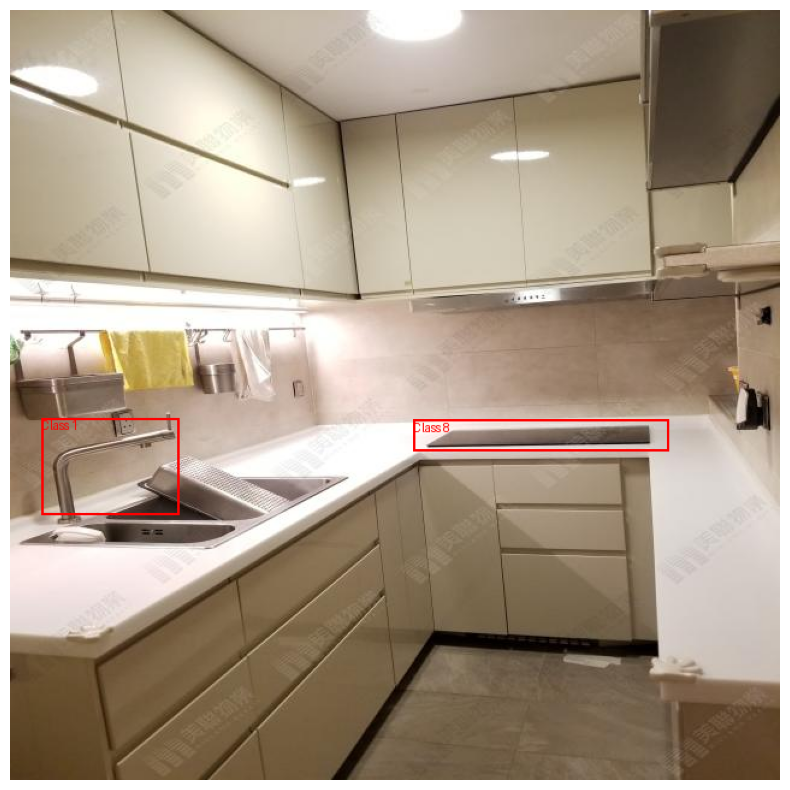

In [8]:
# Read YOLO label file
with open(label_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        class_id = parts[0]
        x_center, y_center, width, height = map(float, parts[1:])

        # Convert from normalized YOLO format to pixel coordinates
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        xmin = x_center - width / 2
        ymin = y_center - height / 2
        xmax = x_center + width / 2
        ymax = y_center + height / 2

        draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=2)
        draw.text((xmin, ymin), f'Class {class_id}', fill='red')

# Show image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


In [9]:
# Load a pretrained model
model = YOLO("yolov8n.pt")

In [10]:
# Train the model
model.train(
    data="/Users/lorenzkrause/projectaria_client_sdk_samples/image_model/fine-tuning/Kitchen-Objects-with-Hands-1/data.yaml",  # path to dataset (for some reason it doesn't work with a relative path for me)
    epochs=100,
    imgsz=640,
    batch=8,
    name="yolov8n_hands_0",
    pretrained=True,
    patience=10                             
)

New https://pypi.org/project/ultralytics/8.3.161 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.80 🚀 Python-3.11.9 torch-2.6.0 CPU (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/lorenzkrause/projectaria_client_sdk_samples/image_model/fine-tuning/Kitchen-Objects-with-Hands-1/data.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_hands_0, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_

train: Scanning /Users/lorenzkrause/projectaria_client_sdk_samples/image_model/fine-tuning/Kitchen-Objects-with-Hands-1/train/labels... 2010 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2010/2010 [00:00<00:00, 3611.07it/s]

train: New cache created: /Users/lorenzkrause/projectaria_client_sdk_samples/image_model/fine-tuning/Kitchen-Objects-with-Hands-1/train/labels.cache



val: Scanning /Users/lorenzkrause/projectaria_client_sdk_samples/image_model/fine-tuning/Kitchen-Objects-with-Hands-1/valid/labels... 83 images, 0 backgrounds, 0 corrupt: 100%|██████████| 83/83 [00:00<00:00, 3325.32it/s]

val: New cache created: /Users/lorenzkrause/projectaria_client_sdk_samples/image_model/fine-tuning/Kitchen-Objects-with-Hands-1/valid/labels.cache


Plotting labels to runs/detect/yolov8n_hands_0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8n_hands_0
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.944      3.473      1.531         32        640: 100%|██████████| 252/252 [05:56<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.92s/it]

                   all         83        514      0.535      0.401      0.411      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.841      2.302      1.481         31        640: 100%|██████████| 252/252 [05:53<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.82s/it]

                   all         83        514      0.595      0.455      0.521      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.785      2.024       1.45          9        640: 100%|██████████| 252/252 [06:04<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.82s/it]

                   all         83        514      0.583      0.582      0.603      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.723      1.838      1.422         21        640: 100%|██████████| 252/252 [05:49<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.81s/it]

                   all         83        514      0.667      0.585      0.643       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.705      1.732      1.405         22        640: 100%|██████████| 252/252 [05:54<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.79s/it]

                   all         83        514       0.75      0.608       0.71      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.704      1.672      1.412         18        640: 100%|██████████| 252/252 [05:59<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]

                   all         83        514      0.798      0.651      0.733      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.681      1.568       1.38         15        640: 100%|██████████| 252/252 [06:24<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

                   all         83        514      0.741      0.667      0.744      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G       1.65      1.511      1.364         19        640: 100%|██████████| 252/252 [06:22<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.753      0.681      0.756      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G       1.63      1.448      1.353         14        640: 100%|██████████| 252/252 [06:25<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.841      0.652      0.765      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G       1.63       1.42      1.351         21        640: 100%|██████████| 252/252 [06:19<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]

                   all         83        514      0.797      0.723      0.787      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.596      1.373      1.336         13        640: 100%|██████████| 252/252 [06:21<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514        0.8      0.738      0.803      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.596      1.326      1.329          6        640: 100%|██████████| 252/252 [06:23<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]

                   all         83        514      0.844      0.728      0.809      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.588      1.302      1.318         18        640: 100%|██████████| 252/252 [06:23<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.84s/it]

                   all         83        514      0.822      0.724      0.793      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.583      1.317      1.323         20        640: 100%|██████████| 252/252 [06:21<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

                   all         83        514      0.829      0.766      0.822      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.564      1.278      1.313         17        640: 100%|██████████| 252/252 [06:04<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.884       0.72      0.823      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.546      1.242      1.297         10        640: 100%|██████████| 252/252 [06:18<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.818      0.741      0.823      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.544      1.215      1.294         25        640: 100%|██████████| 252/252 [06:17<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.89s/it]

                   all         83        514      0.898      0.733      0.828      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.526      1.187      1.291          9        640: 100%|██████████| 252/252 [06:19<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

                   all         83        514       0.86      0.774      0.823      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.521      1.181      1.288          3        640: 100%|██████████| 252/252 [06:20<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]

                   all         83        514      0.839      0.733      0.825      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.509      1.153      1.272         16        640: 100%|██████████| 252/252 [06:20<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]

                   all         83        514      0.871      0.763      0.833      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     21/100         0G      1.509      1.138      1.266         21        640: 100%|██████████| 252/252 [06:20<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

                   all         83        514      0.859      0.776      0.845      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.509      1.122      1.274         28        640: 100%|██████████| 252/252 [06:20<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.92s/it]

                   all         83        514       0.86      0.778      0.847      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.486      1.087      1.267         18        640: 100%|██████████| 252/252 [06:21<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]

                   all         83        514      0.904       0.78      0.867      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.495      1.088      1.267         34        640: 100%|██████████| 252/252 [06:09<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.82s/it]

                   all         83        514      0.892       0.75      0.851       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G       1.48      1.081      1.256         23        640: 100%|██████████| 252/252 [06:04<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

                   all         83        514      0.883      0.758      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.479      1.074      1.256         14        640: 100%|██████████| 252/252 [06:16<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]

                   all         83        514      0.864      0.792      0.858      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G       1.47      1.058      1.244          3        640: 100%|██████████| 252/252 [06:17<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

                   all         83        514      0.897      0.767      0.852        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G       1.45      1.037      1.238         22        640: 100%|██████████| 252/252 [06:22<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]

                   all         83        514      0.873      0.779      0.859      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.457      1.041      1.245         10        640: 100%|██████████| 252/252 [06:20<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]

                   all         83        514      0.857      0.801      0.875       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.435      1.009      1.228          4        640: 100%|██████████| 252/252 [06:19<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.83s/it]

                   all         83        514      0.897      0.792      0.869      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.443      1.006      1.232          9        640: 100%|██████████| 252/252 [06:25<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514       0.89      0.798      0.866      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.435      1.005      1.233          6        640: 100%|██████████| 252/252 [06:17<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]

                   all         83        514      0.851      0.785      0.852      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.428      0.992      1.228         13        640: 100%|██████████| 252/252 [06:18<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.84s/it]

                   all         83        514      0.884      0.776      0.856      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.424     0.9866      1.223          8        640: 100%|██████████| 252/252 [06:02<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.81s/it]

                   all         83        514      0.878      0.805      0.866      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.415      0.973      1.219         25        640: 100%|██████████| 252/252 [06:16<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

                   all         83        514      0.889      0.807      0.861      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.423     0.9819      1.223         12        640: 100%|██████████| 252/252 [06:17<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]

                   all         83        514       0.84      0.846      0.869      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.402     0.9654       1.21         23        640: 100%|██████████| 252/252 [06:19<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]

                   all         83        514      0.909      0.803      0.871      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.407     0.9578      1.214         16        640: 100%|██████████| 252/252 [06:23<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]

                   all         83        514      0.869      0.784      0.848      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.411     0.9541      1.211         33        640: 100%|██████████| 252/252 [06:22<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]

                   all         83        514      0.861      0.806      0.875      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.398     0.9372      1.203         16        640: 100%|██████████| 252/252 [06:22<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.876        0.8      0.879      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G       1.38     0.9184      1.207          6        640: 100%|██████████| 252/252 [06:23<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]

                   all         83        514      0.891      0.785      0.847      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.394     0.9325      1.204          8        640: 100%|██████████| 252/252 [06:22<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]

                   all         83        514      0.901      0.799      0.887      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.385     0.9287        1.2         22        640: 100%|██████████| 252/252 [06:24<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]

                   all         83        514      0.896      0.832      0.886      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.363     0.9073      1.189         25        640: 100%|██████████| 252/252 [06:05<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.869      0.799      0.858      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.365     0.9108      1.194         25        640: 100%|██████████| 252/252 [06:26<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]

                   all         83        514      0.922      0.783      0.875      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.361        0.9      1.188         15        640: 100%|██████████| 252/252 [06:18<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]

                   all         83        514      0.921      0.791      0.879      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     47/100         0G      1.362     0.8999      1.192          6        640: 100%|██████████| 252/252 [06:25<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]

                   all         83        514      0.909      0.791      0.879      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     48/100         0G      1.361     0.9085      1.188         18        640: 100%|██████████| 252/252 [06:22<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.903      0.801      0.869      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     49/100         0G       1.35     0.8971      1.184         27        640: 100%|██████████| 252/252 [06:18<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.882      0.826      0.869      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     50/100         0G      1.353     0.8853       1.18         12        640: 100%|██████████| 252/252 [06:18<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.885      0.818      0.876      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     51/100         0G      1.346     0.8825       1.18         14        640: 100%|██████████| 252/252 [06:18<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.917      0.824      0.887      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.343     0.8781      1.175          6        640: 100%|██████████| 252/252 [06:21<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]

                   all         83        514      0.925      0.801      0.878      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     53/100         0G      1.325     0.8686      1.163         14        640: 100%|██████████| 252/252 [06:19<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]

                   all         83        514      0.916      0.826      0.884      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.335     0.8611      1.166         20        640: 100%|██████████| 252/252 [06:21<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

                   all         83        514      0.921      0.794      0.871      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     55/100         0G      1.318     0.8596      1.161         16        640: 100%|██████████| 252/252 [06:18<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.89s/it]

                   all         83        514      0.903      0.817      0.882      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     56/100         0G       1.32      0.863      1.167         10        640: 100%|██████████| 252/252 [06:26<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.92s/it]

                   all         83        514      0.922      0.801      0.879      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.329     0.8496      1.162         31        640: 100%|██████████| 252/252 [06:24<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.89s/it]

                   all         83        514      0.886      0.791      0.878      0.537
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 47, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

57 epochs completed in 6.246 hours.


Optimizer stripped from runs/detect/yolov8n_hands_0/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_hands_0/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_hands_0/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.9 torch-2.6.0 CPU (Apple M1 Pro)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


                   all         83        514       0.91      0.791      0.879      0.547
                   Cup         26         61      0.864      0.754      0.818      0.441
                Faucet         53         54      0.954      0.768      0.872      0.465
                  Hand         48         64      0.931      0.846       0.93      0.583
                 Pasta         12         13      0.875      0.615      0.689      0.426
                 Plate         33         61       0.95      0.967      0.979        0.7
                   Pot         28         33      0.975      0.667      0.815      0.518
                  Rice          9          9      0.821      0.889      0.975      0.622
                 Spoon         39         70      0.982      0.778      0.883      0.487
                 Stove         50         52      0.855      0.793      0.899      0.613
                   Tea         38         97      0.895      0.835      0.931      0.612
Speed: 0.8ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x309b58210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [11]:
# Load object detection model
model = YOLO('runs/detect/yolov8n_hands_0/weights/best.pt')

In [12]:
# get the model's class names
class_names = model.names
print("Class names:", class_names)

Class names: {0: 'Cup', 1: 'Faucet', 2: 'Hand', 3: 'Pasta', 4: 'Plate', 5: 'Pot', 6: 'Rice', 7: 'Spoon', 8: 'Stove', 9: 'Tea'}


In [13]:
# Run validation on test dataset
metrics = model.val(data="/Users/lorenzkrause/projectaria_client_sdk_samples/image_model/fine-tuning/Kitchen-Objects-with-Hands-1/data.yaml", split="test")

# Access evaluation results
print("mAP50:", metrics.box.map50)
print("mAP50-95:", metrics.box.map)
print("Precision:", metrics.box.p)
print("Recall:", metrics.box.r)
print("F1 Score:", metrics.box.f1)

Ultralytics 8.3.80 🚀 Python-3.11.9 torch-2.6.0 CPU (Apple M1 Pro)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/lorenzkrause/projectaria_client_sdk_samples/image_model/fine-tuning/Kitchen-Objects-with-Hands-1/test/labels... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 2503.72it/s]

val: New cache created: /Users/lorenzkrause/projectaria_client_sdk_samples/image_model/fine-tuning/Kitchen-Objects-with-Hands-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


                   all         84        545      0.921      0.858      0.917       0.56
                   Cup         26         48      0.965      0.708      0.819       0.44
                Faucet         49         50      0.869       0.72      0.883      0.484
                  Hand         44         58      0.914      0.921      0.967      0.654
                 Pasta         11         11      0.823      0.909      0.892      0.406
                 Plate         33         58       0.94      0.948      0.982      0.744
                   Pot         23         27      0.902      0.778      0.851      0.549
                  Rice         11         11      0.987          1      0.995      0.624
                 Spoon         41         97       0.92      0.826      0.893      0.489
                 Stove         49         49      0.946      0.898      0.955      0.645
                   Tea         41        136      0.939      0.868      0.939      0.563
Speed: 1.0ms preproce


0: 640x640 2 Hands, 1 Plate, 1 Pot, 1 Stove, 64.0ms
Speed: 2.3ms preprocess, 64.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


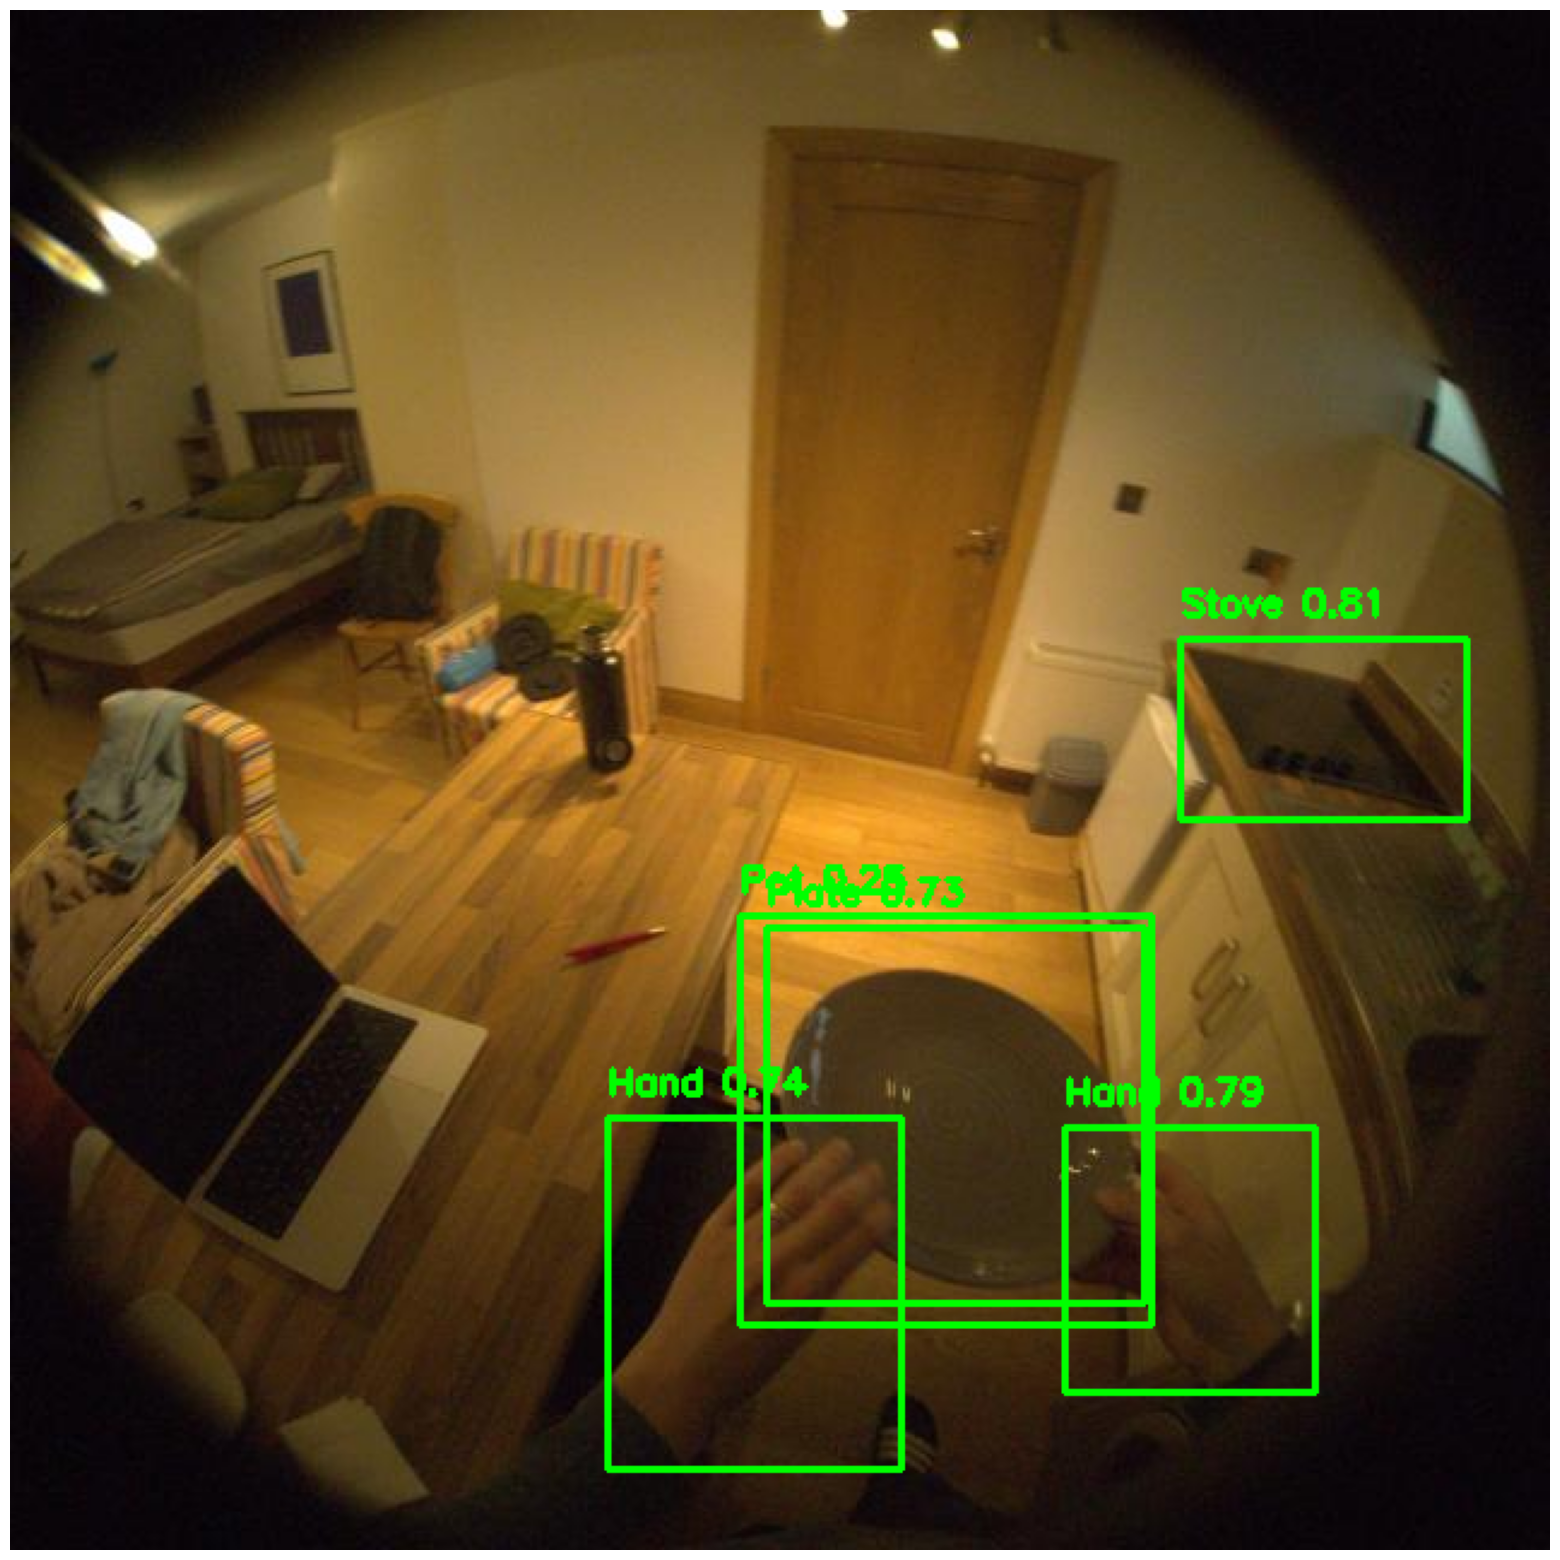

In [16]:
# Load image
image_path = "Kitchen-Objects-with-Hands-1/test/images/214-1-00029-77_383_jpg.rf.272303af33dfb94e8738df9bb3bf915b.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors in Matplotlib

# Run YOLO on the image
results = model(image)

# Draw bounding boxes
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Convert to integer
        conf = box.conf[0].item()  # Confidence score
        cls = int(box.cls[0].item())  # Class ID
        label = f"{model.names[cls]} {conf:.2f}"  # Class name + confidence

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Draw label
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image
plt.figure(figsize=(20, 20))
plt.imshow(image) 
plt.axis("off")
plt.show() 
